In [41]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* 변경하고 싶은 크기 입력 */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [42]:
## 위에 코드 -> 그래프 커도 스크롤 바 안 생기게 하는 코드

## 향수 브랜드별 순위

In [43]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from numpy import random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
rc('font', family='Malgun Gothic')      #한글 폰트설정
plt.rcParams['axes.unicode_minus']=False      #마이너스 부호 출력 설정

In [44]:
from IPython.display import display, HTML    #창 크게 맞게 주피터창 조절
display(HTML("<style>.container { width:100% !important; }</style>"))

In [45]:
npr.seed(10)
ar=np.zeros((10000,17),dtype=int)     #타입 안 정해주면 float 기본

ar[:,0]=np.arange(1,10001)     #id
ar[:,1]=np.random.randint(2,size=10000)        #gender
ar[:,2]=np.random.randint(10,91,size=10000)     #age
ar[:,3]=np.random.randint(1,11,size=10000)     #region
ar[:,4]=np.random.choice([11,22,33,44,55],10000)     #pdt_22 구매상품
ar[:,5]=np.random.choice([11,22,33,44,55],10000)     #pdt_23
ar[:,6]=np.zeros(10000,dtype=int)     #pri_22 가격
ar[:,7]=np.zeros(10000,dtype=int)     #pri_23
ar[:,8]=np.random.randint(1,21,10000)     #count_22 구매개수
ar[:,9]=np.random.randint(1,21,10000)     #count_23
ar[:,10]=np.random.randint(1,25,10000)     #time_22 가장 많이 구매한 시간대
ar[:,11]=np.random.randint(1,25,10000)     #time_23
ar[:,12]=np.random.randint(1,6,size=10000)     #channel 구매한 매장 유형
ar[:,13]=np.random.randint(1,10,size=10000)    #tr_y 누적 회원년수
ar[:,14]=np.zeros(10000,dtype=int)     #pur_22 구매총합
ar[:,15]=np.zeros(10000,dtype=int)     #pur_23
ar[:,16]=np.zeros(10000,dtype=int)     #sales (구매액 증가:1)

############## 데이터프레임 생성 ##############
col=['id','gender','age','region','pdt_22','pdt_23','pri_22','pri_23','ct_22','ct_23',
    'time_22','time_23','channel','tr_y','pur_22','pur_23','sales']

af=pd.DataFrame(ar, columns=col)
af=af.set_index('id')

af_org=af.copy()

############## NaN값 삽입 ##############
random.seed(10)
ac=random.sample(range(10000),10*(len(af.iloc[0])-3))

for i in range(len(af.iloc[0])-3):       #각 칼럼별 nan값 넣기(id, 구매액, 증감 제외)
    nan_c=ac[i*10:(i+1)*10]
    for k in nan_c:
        af.iloc[k,i]=np.nan

af.isnull().sum()
df=af

In [46]:
##### 데이터프레임 생략 없이 뽑기 #####
# pd.set_option('display.max_rows', None) 
# pd.set_option('display.max_columns', None)

In [47]:
##### 나이 범주화 #####
def get_cate(age):
    cat=''
    if age<=39: cat='청년층'
    elif age<=69: cat='중년층'
    else: cat='장년층'
    return cat

df['age_cat']=df.age.apply(lambda x: get_cate(x))

In [48]:
##### 22년 인기상품 남:1, 여:2 #####
idx1 = (df['pdt_22']!=11) &  (df['gender']==0)  #상품11이 아닌 남자
bal=pd.DataFrame(df.pdt_22[idx1])
bal[::8] = pd.DataFrame([11 for i in range(len(bal[::8]))])
df.pdt_22[idx1]=bal.pdt_22

idx2 = (df['pdt_22']!=22)  &  (df['gender']==1)   #상품22가 아닌 여자
bal=pd.DataFrame(df.pdt_22[idx2])
bal[::8] = pd.DataFrame([22 for i in range(len(bal[::8]))])
df.pdt_22[idx2]=bal.pdt_22

##### 23년 인기상품 남,여:3 #####
idx1 = df['pdt_23']!=33      #상품33이 아닌
bal=pd.DataFrame(df.pdt_23[idx1])
bal[::10] = pd.DataFrame([33 for i in range(len(bal[::10]))])
df.pdt_23[idx1]=bal.pdt_23

##### 각 인기상품 구매개수 상승 #####
idx1 = (df['pdt_22']==11) &  (df['gender']==0)
idx2 = (df['pdt_22']==22)  &  (df['gender']==1)
df.ct_22[idx1 | idx2] +=10

idx3 = df['pdt_23']==3
df.ct_23[idx3] += 5

In [49]:
##### 23년 상품 구매수 변화 #####
#구매증가 
idx1 = df['pdt_23']==44
df.ct_23[idx1] +=30
idx1 = df['pdt_23']==33
df.ct_23[idx1] +=5
idx1 = df['pdt_23']==55
df.ct_23[idx1] +=15

#구매감소 
idx1 = (df['pdt_23']==11) | (df['pdt_23']==22)
df.ct_23[idx1] = (df.ct_23[idx1]//5 +1)*4

#22년 4번 조금 내림
idx1 = df['pdt_22']==44
df.ct_23[idx1] =(df.ct_23[idx1]//5+1)*4

In [50]:
##### 나이대별 선호 구매장소 #####
# 청년층 인터넷/ 중년층 백화점/ 장년층 면세점
idx1 = (df['channel']!=4) &  (df['age_cat']=='청년층')
bal=pd.DataFrame(df.channel[idx1])
bal[::10] = pd.DataFrame([4 for i in range(len(bal[::10]))])
df.channel[idx1]=bal.channel

idx2 = (df['channel']!=2) &  (df['age_cat']=='중년층')
bal=pd.DataFrame(df.channel[idx2])
bal[::10] = pd.DataFrame([2 for i in range(len(bal[::10]))])
df.channel[idx2]=bal.channel

idx3 = (df['channel']!=1) &  (df['age_cat']=='장년층')
bal=pd.DataFrame(df.channel[idx3])
bal[::3] = pd.DataFrame([1 for i in range(len(bal[::3]))])
df.channel[idx3]=bal.channel

# 올리브영 -> 중년층이 너무 많아서 청년층으로 바꿈
idx3 = (df['channel']==5) &  (df['age_cat']=='중년층')
bal=pd.DataFrame(df.age[idx3])
bal[::6] = pd.DataFrame(np.random.randint(10,40, len(bal[::6])))
df.age[idx3]=bal.age

df['age_cat']=df.age.apply(lambda x: get_cate(x))  #나이를 바꿔서 age_cat도 다시 넣어줌

In [51]:
##### 구매장소 #####
# 1. 면세점: 젤 비싼 제품들 위주/ 인당 구매 개수가 많은 편
# 2. 백화점: 젤 비싼 제품들 위주/ 구매자 수가 많은 편
# 3. 향수전문점 : 전체적으로 매출 낮음/ 단, 프리미엄 라인 잘 팔림
# 4. 인터넷: 전체적으로 매출 높음/ 구매자수 가장 많음
# 5. 올리브영: 저가형 제품 많음
    
# 인터넷, 향수전문점, 면세점 구매자수 조절
idx1 = (df['channel']!=4)
bal=pd.DataFrame(df.channel[idx1])
bal[::10] = pd.DataFrame([4 for i in range(len(bal[::10]))])
df.channel[idx1]=bal.channel

idx1 = (df['channel']==3)
bal=pd.DataFrame(df.channel[idx1])
bal[::3] = pd.DataFrame(np.random.choice([1,2,4,5],len(bal[::3])))
df.channel[idx1]=bal.channel

idx1 = (df['channel']==1)
bal=pd.DataFrame(df.channel[idx1])
bal[::3] = pd.DataFrame(np.random.choice([2,3,4,5],len(bal[::3])))
df.channel[idx1]=bal.channel

# 면세점/백화점: 22년(4,5번), 23년(2,5번) 제품 위주/ 인당 구매 수량 많음
idx1 = (df['channel']==1) | (df['channel']==2)
idx2 = (df['pdt_22']!=44) | (df['pdt_22']!=55)
idx2 = (df['pdt_23']!=22) | (df['pdt_23']!=55)

bal=pd.DataFrame(df.pdt_22[idx1&idx2])
bal[::3] = pd.DataFrame(np.random.choice([44,55],len(bal[::3])))
df.pdt_22[idx1&idx2]=bal.pdt_22
df.ct_22[idx1&idx2]+=5

bal=pd.DataFrame(df.pdt_23[idx1&idx3])
bal[::3] = pd.DataFrame(np.random.choice([22,55],len(bal[::3])))
df.pdt_23[idx1&idx3]=bal.pdt_23
df.ct_23[idx1&idx3]+=5

# 향수전문점: 22년(4,5번), 23년(5번) 제품 위주
idx1 = df['channel']==3
idx2 = (df['pdt_22']!=44) | (df['pdt_22']!=55)
idx2 = df['pdt_23']!=55

bal=pd.DataFrame(df.pdt_22[idx1&idx2])
bal[::3] = pd.DataFrame(np.random.choice([44,55],len(bal[::3])))
df.pdt_22[idx1&idx2]=bal.pdt_22

bal=pd.DataFrame(df.pdt_23[idx1&idx3])
bal[::4] = pd.DataFrame(np.random.choice([55],len(bal[::4])))
df.pdt_23[idx1&idx3]=bal.pdt_23

# 올리브영: 22년(1,2,3), 23년(1,3,4) 위주
idx1 = df['channel']==5
idx2 = (df['pdt_22']!=11) | (df['pdt_22']!=22) | (df['pdt_22']!=33)
idx2 = (df['pdt_22']!=11) | (df['pdt_22']!=33) | (df['pdt_22']!=44)

bal=pd.DataFrame(df.pdt_22[idx1&idx2])
bal[::2] = pd.DataFrame(np.random.choice([11,22,33],len(bal[::2])))
df.pdt_22[idx1&idx2]=bal.pdt_22

bal=pd.DataFrame(df.pdt_23[idx1&idx3])
bal[::2] = pd.DataFrame(np.random.choice([11,33,44],len(bal[::2])))
df.pdt_23[idx1&idx3]=bal.pdt_23

In [52]:
##### 구매 시간대 #####
# 인터넷 제외, 00~09시, 22~24시는 구매x -> 매장운영x
idx1 = df['channel']!=4 

bal=pd.DataFrame(df.time_22[idx1])
bal[::] = pd.DataFrame(np.random.randint(9,23,size=len(bal)))
df.time_22[idx1]=bal.time_22

bal=pd.DataFrame(df.time_23[idx1])
bal[::] = pd.DataFrame(np.random.randint(9,23,size=len(bal)))
df.time_23[idx1]=bal.time_23

In [53]:
##### 회원 누적연도에 따른 구매 증가 #####
for i in range(3,10):
    idx = df['tr_y']>=i
    df.ct_22[idx] += np.random.randint(0,3,len(df[idx]))
    df.ct_23[idx] += np.random.randint(0,3,len(df[idx]))

In [54]:
#### 22년 대비 23년 매출감소
df.ct_23 = (df.ct_23//5+1)*3

In [55]:
# nan값 처리/ 각 상품에 맞는 가격 삽입/ 데이터 타입변경
df.dropna(subset=['pdt_22', 'pdt_23', 'ct_22', 'ct_23', 'pur_22', 'pur_23'], axis=0, inplace=True)
df.age.replace(np.nan, 0, inplace=True)
df.tr_y.replace(np.nan, 0, inplace=True)

idx = df['age']==0
df.age_cat[idx]='정보없음'

t22=df['time_22'].value_counts(dropna=True).idxmax()    #가장 많이 등장한 값 뽑기
df['time_22'].fillna(t22, inplace=True)
t23=df['time_23'].value_counts(dropna=True).idxmax()
df['time_23'].fillna(t23, inplace=True)

price_dict1 = {11: 2000, 22: 3000, 33: 4000, 44: 7000, 55: 10000}
price_dict2 = {11: 3000, 22: 6000, 33: 2000, 44: 5000, 55: 12000}
df['pri_22'] = df['pdt_22'].map(price_dict1)
df['pri_23'] = df['pdt_23'].map(price_dict2)

df['pur_22'] = df['pri_22'] * df['ct_22']
df['pur_23'] = df['pri_23'] * df['ct_23']
df['sales'] = np.where(df['pur_22']-df['pur_23'] > 0, 0,1)

df[['age','time_22','time_23','pur_22','pur_23','pri_22','pri_23','ct_22','ct_23','tr_y']]=df[['age','time_22','time_23','pur_22','pur_23','pri_22','pri_23','ct_22','ct_23','tr_y']].astype('int')

In [56]:
# 데이터명 수정/ 매출 총액, 전년대비 매출 증감폭 칼럼 추가/ 안 쓰는 칼럼 삭제
df.gender.replace({0:'남성',1:'여성', np.nan:'정보없음'}, inplace=True)
df['pdt_22'].replace({11:'조말론',22:'샤넬',33:'랑방',44:'디올',55:'에르메스'}, inplace=True)
df['pdt_23'].replace({11:'조말론',22:'샤넬',33:'랑방',44:'디올',55:'에르메스'}, inplace=True)
df.channel.replace({1:'면세점',2:'백화점',3:'향수전문점',4:'인터넷',5:'올리브영',np.nan:'기타'}, inplace=True)

df.insert(15,'pur_all', df.pur_22 + df.pur_23)
df.insert(16,'pur_gap', abs(df.pur_23 - df.pur_22))

df=df.drop('region',axis=1)

In [57]:
# df.isnull().sum()

In [58]:
df.tail()

,gender,age,pdt_22,pdt_23,pri_22,pri_23,ct_22,ct_23,time_22,time_23,channel,tr_y,pur_22,pur_23,pur_all,pur_gap,sales,age_cat
id,,,,,,,,,,,,,,,,,,
9996,남성,63,에르메스,랑방,10000,2000,29,21,2,14,인터넷,9,290000,42000,332000,248000,0,중년층
9997,여성,65,디올,디올,7000,5000,11,27,11,20,백화점,5,77000,135000,212000,58000,1,중년층
9998,여성,42,랑방,랑방,4000,2000,13,12,9,11,올리브영,8,52000,24000,76000,28000,0,중년층
9999,남성,69,랑방,랑방,4000,2000,20,6,21,11,인터넷,2,80000,12000,92000,68000,0,중년층
10000,여성,23,랑방,에르메스,4000,12000,29,15,22,22,올리브영,5,116000,180000,296000,64000,1,청년층


### 채널별 인기상품

Text(1.0, 1.0, '23년 장소별 판매상품 수')

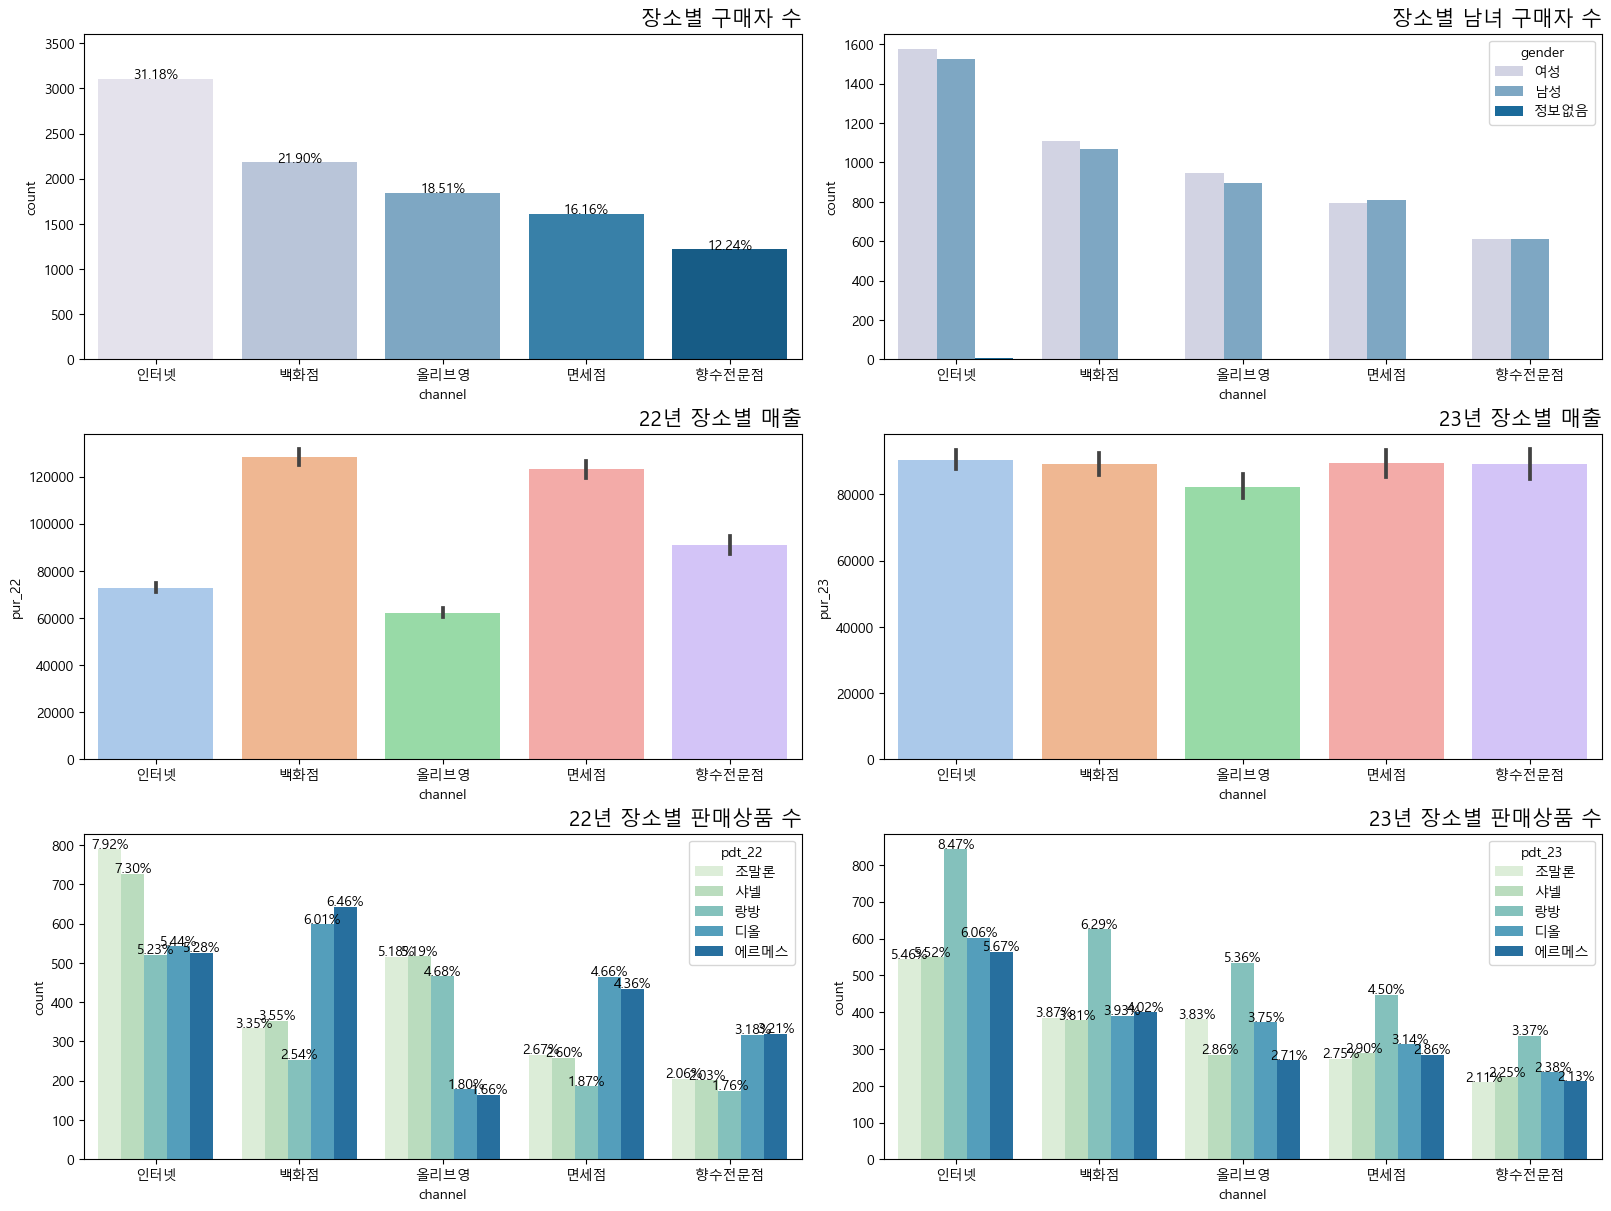

In [59]:
##### 구매장소에 따른 구매자수, 매출 확인 #####
# 구매장소별 구매자수/ 22년 장소별 매출/ 
# 22년 장소별,상품별 매출/ 장소별, 상품별 구매자수

idx=df['channel']!='기타'; af = df[idx]
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,12), constrained_layout=True)
#=================================================================================
sns.countplot(x='channel', data=af, palette='PuBu', ax=ax[0,0])

total = float(len(af))  # 데이터 전체 개수
ax[0,0].set_ylim([0, max(af['channel'].value_counts()) + 500])
for p in ax[0,0].patches:
    height = p.get_height()
    ax[0,0].text(p.get_x()+p.get_width()/2., height+3, '{:.2f}%'.format(height/total*100), ha="center")
#=================================================================================
sns.countplot(x='channel', data=af, hue='gender', palette='PuBu', ax=ax[0,1])

sns.barplot(x='channel', y='pur_22', data=af, palette='pastel', ax=ax[1,0])
sns.barplot(x='channel', y='pur_23', data=af, palette='pastel', ax=ax[1,1])
#=================================================================================
order=['조말론','샤넬','랑방','디올','에르메스']
sns.countplot(x='channel', hue='pdt_22', data=af, palette='GnBu', hue_order=order, ax=ax[2,0])

total_products_22 = float(len(af.dropna(subset=['pdt_22'])))  # 22년 전체 판매 상품 수
for p in ax[2,0].patches:
    height = p.get_height()
    ax[2,0].text(p.get_x()+p.get_width()/2., height+3, '{:.2f}%'.format(height/total_products_22*100), ha="center")
#=================================================================================
sns.countplot(x='channel', hue='pdt_23', data=af, palette='GnBu', hue_order=order, ax=ax[2,1])

total_products_23 = float(len(af.dropna(subset=['pdt_23'])))  # 23년 전체 판매 상품 수
for p in ax[2,1].patches:
    height = p.get_height()
    ax[2,1].text(p.get_x()+p.get_width()/2., height+3, '{:.2f}%'.format(height/total_products_23*100), ha="center")
#=================================================================================
ax[0,0].set_title("장소별 구매자 수",loc='right',size=15)
ax[0,1].set_title("장소별 남녀 구매자 수",loc='right',size=15)
ax[1,0].set_title("22년 장소별 매출",loc='right',size=15)
ax[1,1].set_title("23년 장소별 매출",loc='right',size=15)
ax[2,0].set_title("22년 장소별 판매상품 수",loc='right',size=15)
ax[2,1].set_title("23년 장소별 판매상품 수",loc='right',size=15)

### 성별에 따른 인기상품

In [60]:
##### 성별에 따른 인기상품 확인 #####
a = df.groupby(['gender','pdt_22'])
ap22 = a.agg({'ct_22':['sum','count']})

b = df.groupby(['gender','pdt_23'])
bp23 = b.agg({'ct_23':['sum','count']})

# ap22
bp23

ct_23      
                 sum count
gender pdt_23             
남성     디올      25131   942
       랑방      17859  1360
       샤넬       8421   850
       에르메스    16191   867
       조말론      9396   900
여성     디올      26091   975
       랑방      18477  1425
       샤넬       8952   880
       에르메스    16281   862
       조말론      9375   894
정보없음   디올         54     2
       랑방         48     3
       샤넬         12     1
       에르메스       78     4

In [61]:
idx = df.loc[df['gender']=='정보없음'].index
df_n = df.drop(idx)

q=df_n.groupby(['gender','pdt_22'])
w=df_n.groupby(['gender','pdt_23'])

wdf=w.count()
wdf1=wdf[['pdt_22']]

qdf=q.count()
qdf1=qdf[['pdt_23']]
qdf1

rate=(wdf1['pdt_22'] - qdf1['pdt_23']) / wdf1['pdt_22']*100
df_rate=pd.DataFrame(rate)
df_rate

cdf=pd.concat([qdf1,wdf1,df_rate],axis=1)

cdf=cdf.rename(columns={'pdt_22':'2023', 'pdt_23':'2022', 0:'증감률(%)'})
cdf

2022  2023     증감률(%)
gender                            
남성     디올    1073   942 -13.906582
       랑방     774  1360  43.088235
       샤넬     791   850   6.941176
       에르메스  1029   867 -18.685121
       조말론   1252   900 -39.111111
여성     디올    1029   975  -5.538462
       랑방     826  1425  42.035088
       샤넬    1265   880 -43.750000
       에르메스  1054   862 -22.273782
       조말론    862   894   3.579418

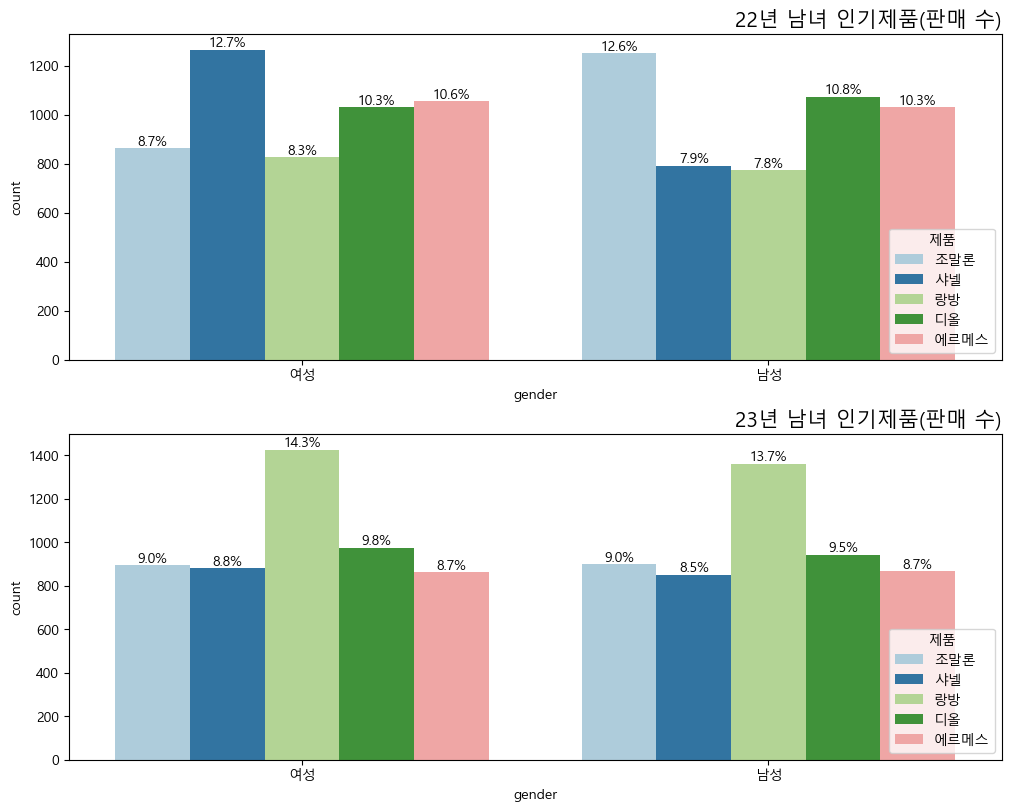

In [62]:
##### 성별에 따른 인기상품 확인 #####
idx=df['gender']!='정보없음'
af = df[idx]

fig, axs = plt.subplots(nrows=2, figsize=(10,8), constrained_layout=True)

order=order=['조말론','샤넬','랑방','디올','에르메스']     # hue라벨 순서
sns.countplot(x='gender', hue='pdt_22', data=af, palette='Paired', hue_order=order, ax=axs[0])
sns.countplot(x='gender', hue='pdt_23', data=af, palette='Paired', hue_order=order, ax=axs[1])

#그래프 위에 비율 표시하기
for ax_idx, col_name in zip([0, 1], ['pdt_22', 'pdt_23']):
    ax = axs[ax_idx]
    for patch in ax.patches:
        x_pos = patch.get_x() + patch.get_width() / 2
        y_pos = patch.get_height()
        total = float(len(af))
        ratio = y_pos / total * 100
        ax.text(x_pos, y_pos, f'{ratio:.1f}%', ha='center', va='bottom')

axs[0].legend(title='제품', loc='lower right')
axs[1].legend(title='제품', loc='lower right')

axs[0].set_title("22년 남녀 인기제품(판매 수)",loc='right', size=15)
axs[1].set_title("23년 남녀 인기제품(판매 수)",loc='right', size=15)
plt.show()

### 성별 선호 브랜드의 차이
    - 남:조말론, 여:샤넬 
     ==> 가격 변동 이후 남녀 모두 랑방으로 선호도 변화
        - 조말론 50% 상승/ 샤넬 100% 상승 / 랑방 50% 하락 / 디올 약 29% 하락 / 에르메스 20% 상승
- 조말론의 가격이 상승에 따른 변화
    - 반면, 남성은 3.8% 감소했기에 이를 위해서 증정품 증정 등 남성을 위한 행사도 좋을 듯 하다.
<br><br>
- 샤넬 브랜드는 가격이 상승에 따른 변화
    - 가격의 100% 상승으로 여성의 구매율은 4%정도 하락함
    - 샤넬은 총 구매수의 10% 이상은 차지하기 때문에 가격에 대한 정책을 생각해봐야할 것 같다.
<br><br>
- 랑방
    - 50% 하락으로 여성, 남성 모두 상승. 그러나 아래 가격변화로 인한 총매출 변화를 보면 보완 필요
<br><br>
- 디올은 29% 하락했는데 여성, 남성 모두 하락. 가격이 비싸야 구매욕구를 주는 것 같다. 다시 올리기
<br><br>
- 에르메스
    - 20% 가격이 상승함에 따라 여성, 남성의 판매수는 줄었다. 그러나 아래 총매출을 확인하면 가격상승이 판매수 감소를 커버함.

### 연령대에 따른 채널 선호도

In [63]:
##### 연령에 따른 채널 선호도 확인 #####
a = df.groupby(['age_cat','channel'])
ap22 = a.agg({'channel':'count'})
ap22

channel
age_cat channel         
장년층     기타             2
        면세점          724
        백화점          446
        올리브영         391
        인터넷          634
        향수전문점        306
정보없음    면세점            3
        백화점            2
        올리브영           2
        인터넷            2
        향수전문점          1
중년층     기타             1
        면세점          426
        백화점         1052
        올리브영         677
        인터넷         1067
        향수전문점        443
청년층     기타             5
        면세점          456
        백화점          681
        올리브영         773
        인터넷         1402
        향수전문점        469

Text(1.0, 1.0, '채널에 따른 연령대별 선호도')

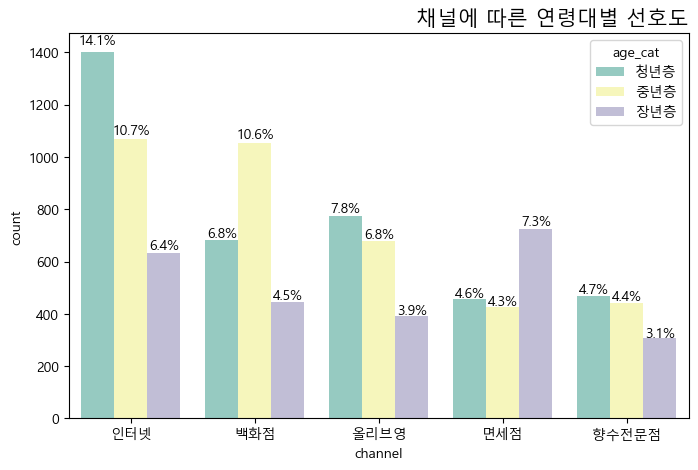

In [64]:
##### 채널별 특정 연령 선호도 확인 #####
idx=df['channel']!='기타'; af = df[idx]

plt.figure(figsize=(8,5))
order=['청년층','중년층','장년층']
ax = sns.countplot(x='channel', hue='age_cat', hue_order=order, data=af, palette='Set3')

#막대 그래프들 위에 %수치 표시
total_count = len(af)
for p in ax.patches:
    height = int(p.get_height())
    x, y = p.get_xy()
    percentage = height / total_count * 100
    ax.text(x + p.get_width() / 2, y + height * 1.02, f'{percentage:.1f}%', ha='center')

plt.title('채널에 따른 연령대별 선호도', loc='right', size=15)

### 연령별 선호 채널의 차이
    - 청년층:인터넷, 중년층:백화점, 장년층:면세점 선호하는 양상.
    - 채널별 인기상품 그래프 중 22-23년 장소별 구매자수를 보면 5개의 장소 중 인터넷의 구매자 수가 31%로 제일 높다. 
      아무래도 인터넷에 익숙한 청년들이기에 청년들이 가장 높은데 인터넷의 구매자를 높이려면 좀 더 인터넷의 장벽을 낮추면 좋을 것 같다.
      ex) 어르신들은 티비에서 사는 것처럼 전화로 구매하는 등, 구매 방법의 단순화 등 
    - 년도를 비교해서 보면 인터넷, 올리브영, 향수전문점에서의 매출이 상승한 것을 알 수 있다. 
      이에 비해 백화점과 면세점의 매출은 떨어졌는데, 주력 상품이었던 고가 제품들이 잇따라 가격을 내리며 이미지에 타격을 받았을 것으로 예상. 기존 주력 상품들의 구매가 줄어들고, 그 외에 일부 상품들의 구매가 늘었음.

### 채널별 구매 시간대 확인

In [65]:
##### 구매 시간대 확인 #####
a = df.groupby(['channel','time_22'])
ap22 = a.agg({'time_22':'count'})
ap22

time_22
channel time_22         
기타      13             1
        16             1
        17             2
        18             1
        19             1
...                  ...
향수전문점   18            70
        19            77
        20            80
        21           102
        22            92

[87 rows x 1 columns]

In [66]:
##### 구매 시간대 확인 #####
dic1,dic2,dic3,dic4,dic5=[0]*25, [0]*25, [0]*25, [0]*25, [0]*25   #각 장소별 시간대 카운트
listdic=[dic1,dic2,dic3,dic4,dic5]
chlist=['면세점','백화점','향수전문점','인터넷','올리브영']

for k in range(len(chlist)):   #장소
    idx1 = df['channel']==chlist[k]
    for i in range(25):    #시간대
        idx2 =  (df['time_22']==i) | (df['time_23']==i)
        listdic[k][i] = len(df[idx1 & idx2])

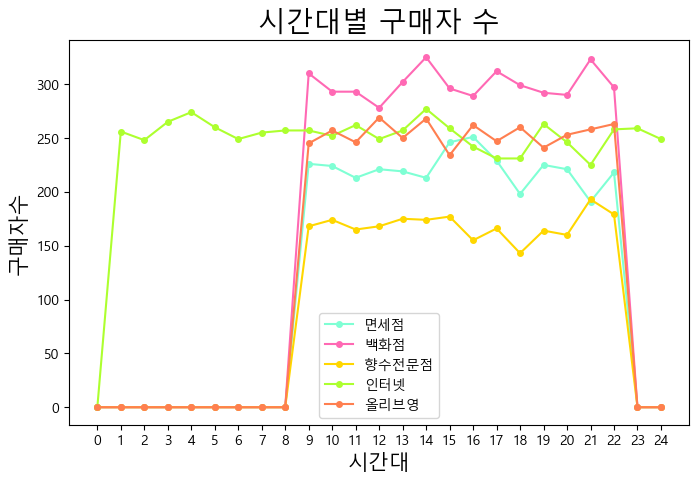

In [67]:
##### 구매 시간대 확인 #####
x=np.arange(25)
y1, y2, y3, y4, y5 =listdic[0], listdic[1], listdic[2], listdic[3], listdic[4]

ax = plt.figure(figsize=(8,5)).add_subplot(1,1,1)
ticks = ax.set_xticks([i for i in range(0,25)])

plt.plot(x,y1, color='aquamarine', marker='o', markersize=4, label="면세점")
plt.plot(x,y2, color='hotpink', marker='o', markersize=4, label="백화점")
plt.plot(x,y3, color='gold', marker='o', markersize=4, label="향수전문점")
plt.plot(x,y4, color='greenyellow', marker='o', markersize=4, label="인터넷")
plt.plot(x,y5, color='coral', marker='o', markersize=4, label="올리브영")

plt.title('시간대별 구매자 수', size=20)
plt.xlabel('시간대',size=15)
plt.ylabel('구매자수',size=15)
plt.legend()

### 회원 누적연도에 따른 구매량

In [68]:
##### 누적연도에 따른 구매증가 확인 #####
a = df.groupby(['tr_y'])
ap22 = a.agg({'ct_22':'sum', 'pur_22':['sum','mean'], 'ct_23':'sum', 'pur_23':['sum','mean']}).round(1)
ap22

ct_22     pur_22            ct_23     pur_23          
        sum        sum      mean    sum        sum      mean
tr_y                                                        
0       150     542000   54200.0    141     915000   91500.0
1     16687   84085000   77213.0  14937   86475000   79407.7
2     16873   82818000   74948.4  15207   87822000   79476.9
3     18199   89175000   80555.6  16200   93255000   84241.2
4     18101   89788000   85512.4  15738   87924000   83737.1
5     20182  102803000   93118.7  17184   98319000   89057.1
6     21808  112832000   99674.9  18258  101025000   89244.7
7     22880  118657000  106228.3  18822  104505000   93558.6
8     24628  124893000  108791.8  19674  109263000   95176.8
9     24729  123766000  112208.5  20205  110868000  100515.0

Text(1.0, 1.0, '23년 회원년도별 매출 평균')

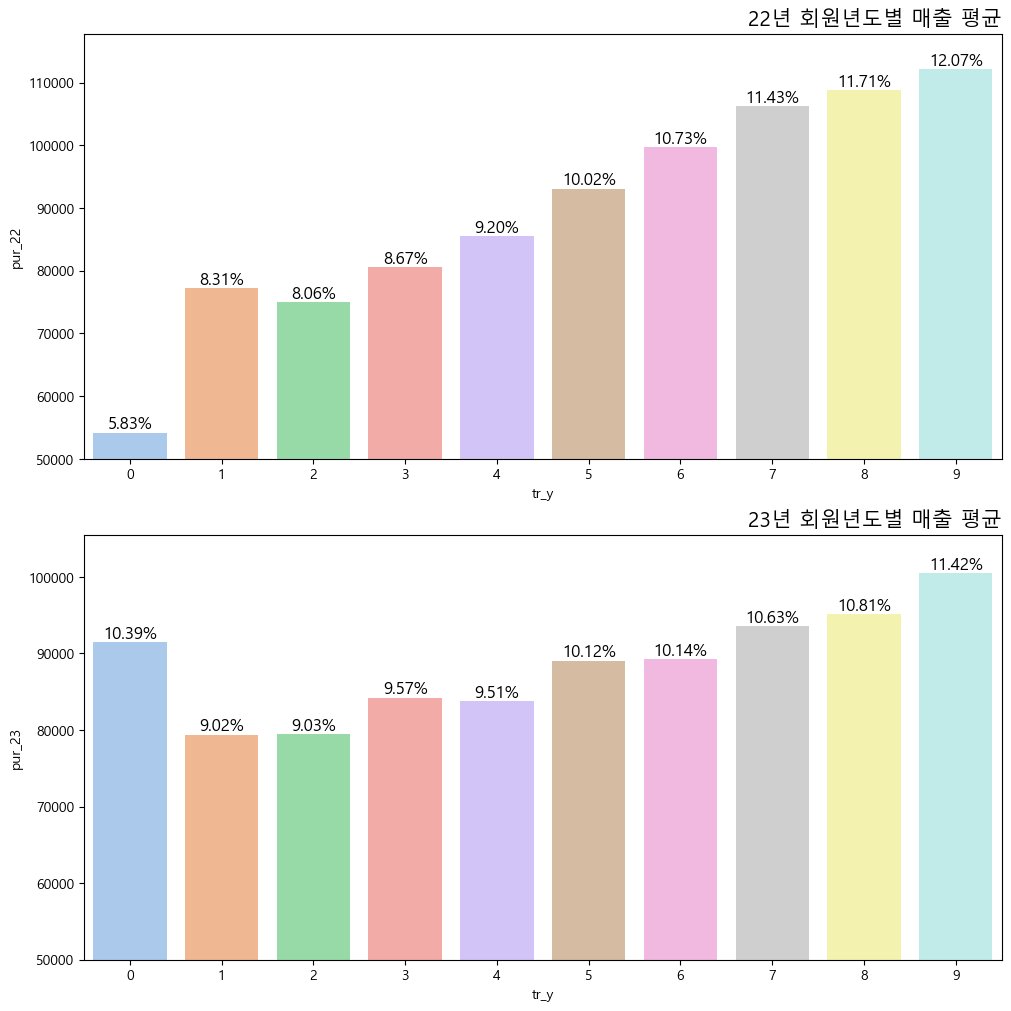

In [69]:
fig, ax = plt.subplots(nrows=2, figsize=(10,10), constrained_layout=True)

#===================#### 그래프 위에 % 수치 표기 #####================================
# 누적년도별 매출 합 구하기
tot_pur_22 = df['pur_22'].sum()
tot_pur_23 = df['pur_23'].sum()

# 누적년도별 매출 평균 계산하기
pur_mean_22 = df.groupby('tr_y')['pur_22'].mean().reset_index()
pur_mean_23 = df.groupby('tr_y')['pur_23'].mean().reset_index()

for i, pur_mean in enumerate([pur_mean_22, pur_mean_23]):
    # 그래프 그리기
    sns.barplot(x='tr_y', y=pur_mean.columns[1], data=pur_mean, palette='pastel', ax=ax[i])
    ax[i].set_ylim(bottom=50000,top=None)     #그래프 아래쪽 생략(너무 길어서)
    
    # 각 그래프 위에 수치 표시하기
    for p in ax[i].patches:
        height = p.get_height()
        if i == 0:  ratio = height / tot_pur_22
        else:    ratio = height / tot_pur_23
        ax[i].text(p.get_x() + p.get_width() / 2, height, 
                   '{:.2%}'.format(ratio*1000), 
                   fontsize=12, color='black', ha='center', va='bottom')
#========================================================================================

ax[0].set_title("22년 회원년도별 매출 평균",loc='right', size=15)
ax[1].set_title("23년 회원년도별 매출 평균",loc='right', size=15)

In [70]:
# ##### 누적연도에 따른 구매증가 확인 #####
# fig, ax = plt.subplots(nrows=2, figsize=(10,10), constrained_layout=True)       # constrained_layout=True: 각 그래프 간 간격 최적화

# #===================#### 그래프 위에 % 수치 표기 #####================================
# # 누적년도별 매출 평균 계산하기
# pur_mean_22 = df.groupby('tr_y')['pur_22'].mean().reset_index()
# pur_mean_23 = df.groupby('tr_y')['pur_23'].mean().reset_index()

# for i, pur_mean in enumerate([pur_mean_22, pur_mean_23]):
#     # 그래프 그리기
#     sns.barplot(x='tr_y', y=pur_mean.columns[1], data=pur_mean, palette='pastel', ax=ax[i])
#     ax[i].set_ylim(bottom=50000,top=None)     #그래프 아래쪽 생략(너무 길어서)
    
#     # 각 그래프 위에 수치 표시하기
#     for p in ax[i].patches:
#         ax[i].text(p.get_x() + p.get_width() / 2, p.get_height(), 
#                    '{:.2f}%'.format(p.get_height() / comp_val_22 * 100 if i == 0 else p.get_height() / comp_val_23 * 100), 
#                    fontsize=12, color='black', ha='center', va='bottom')
# #========================================================================================

# ax[0].set_title("22년 회원 누적년도별 매출 평균",loc='right', size=15)
# ax[1].set_title("23년 회원 누적년도별 매출 평균",loc='right', size=15)

### 22년 대비 23년 상품별 매출

In [71]:
# 제품별 매출/개수
a = df.groupby(['pdt_22'])
ap22 = a.agg({'pur_22':'sum', 'ct_22':'sum'}).round(1)

a = df.groupby(['pdt_23'])
ap23 = a.agg({'pur_23':'sum', 'ct_23':'sum'}).round(1)

In [72]:
## 22년 대비 23년 매출: 약 5% 하락
(1 - (df.pur_23.sum() / df.pur_22.sum())) *100

5.271160014590704

In [73]:
df22_23 = pd.DataFrame(index=['조말론','샤넬','랑방','디올','에르메스'])

df22_23['price'] = ['+50%','+100%','-50%','-28.57%','+20%']    #전년대비 가격 상승률

df22_23['p22'] = ap22.pur_22   #22년 제품 매출
df22_23['p23'] = ap23.pur_23   #23년 제품 매출
df22_23['pur'] = ap23.pur_23 - ap22.pur_22     #각 상품별 매출액 추이
df22_23['pur%'] = ((ap23.pur_23 / (ap22.pur_22/100))-100).round(2)    #22년 대비 매출 증감%

df22_23['c22'] = ap22.ct_22  #22년 제품 판매 개수
df22_23['c23'] = ap23.ct_23  #23년 제품 판매 개수
df22_23['count%'] = ((df22_23.c23/(df22_23.c22/100))-100).round(2)     #각 상품별 구매량(개수) 증감

df22_23['22 매출비율'] = ((df22_23.p22 / df22_23.p22.sum())*100).round(1)   #22년 상품별 매출비율
df22_23['23 매출비율'] = ((df22_23.p23 / df22_23.p23.sum())*100).round(1)   #23년 상품별 매출비율
df22_23['percent'] = df22_23['23 매출비율'] - df22_23['22 매출비율']   #상품별 매출비율 증감

a,b,c,d,e = df22_23.p22.sum(), df22_23.p23.sum(), df22_23.pur.sum(), df22_23.c22.sum(), df22_23.c23.sum()
f = ((b/(a/100))-100).round(2)
g = ((e/(d/100))-100).round(2)
df22_23.loc[len(df22_23)] = ['+7.69%',a,b,c,f, d,e,g, 100, 100,0]
df22_23 = df22_23.rename(index={5:'총계'})

df22_23

,price,p22,p23,pur,pur%,c22,c23,count%,22 매출비율,23 매출비율,percent
조말론,+50%,88670000,56313000,-32357000,-36.49,44335,18771,-57.66,9.5,6.4,-3.1
샤넬,+100%,129576000,104310000,-25266000,-19.50,43192,17385,-59.75,13.9,11.8,-2.1
랑방,-50%,97828000,72768000,-25060000,-25.62,24457,36384,48.77,10.5,8.3,-2.2
디올,-28.57%,254905000,256380000,1475000,0.58,36415,51276,40.81,27.4,29.1,1.7
에르메스,+20%,358380000,390600000,32220000,8.99,35838,32550,-9.17,38.6,44.4,5.8
총계,+7.69%,929359000,880371000,-48988000,-5.27,184237,156366,-15.13,100.0,100.0,0.0


### 가격 변동에 따른 브랜드 구매량의 변화
우선 22년 대비 23년 매출 5% 하락 (국내외적인 물가 불안정 등)

- 조말론,샤넬: 판매수량 약 50-60% 크게 감소(거의 절반 가까이 down, 작년대비 약 %12감소), 그래서 매출도 감소. 
    - 그렇지만 원그래프에서 총매출비율을 보면 전년대비 2-3% 하락
    - 이는 앞서 말했듯이 총 매출이 작년대비 5% 하락했고, 
    - 작년대비 조말로는 가격이 50%, 샤넬은 100% 증가한 것이 총매출비율에서 2-3% 정도만 하락할 수 있었던 원인이라 볼 수 있다.
  -> 구매율을 높이기 위한 가격 인하 또는 작은 사은품 증정 등 행사를 하면 좋을 것 같다.
<br><br>
- 랑방: 판매수량은 약 48% 정도 올랐는데 매출은 26% 하락
    - 가격이 작년대비 50%정도 떨어진 것이 영향. 그래서 총매출 비율에서도 2% 정도 하락. 
    - 가격이 떨어져서 수량이 올랐지만, 매출이 하락했다면 가격하락을 좀 덜 해도 좋을 것 같다.
<br><br>
- 디올: 판매수량, 매출 모두 up
    - 가격 인하를 했음에도 매출이 늘지 않은 브랜드.
    - 가격이 29% 하락했음에도 불구하고 판매 수량은 41% 증가했고 총매출 비율도 1.7% 상승
<br> <br>  
- 에르메스: 가격이 20% 상승했음에도 수량이 크게 줄지 않음 -> 매출 약 6% up
    - 가격 상승을 했음에도 매출이 꾸준한 브랜드.
<br>  <br>  
- 구매량에 많은 변화가 있지만 결과적으로 총 매출 순위에는 큰 변동이 없는 양상.

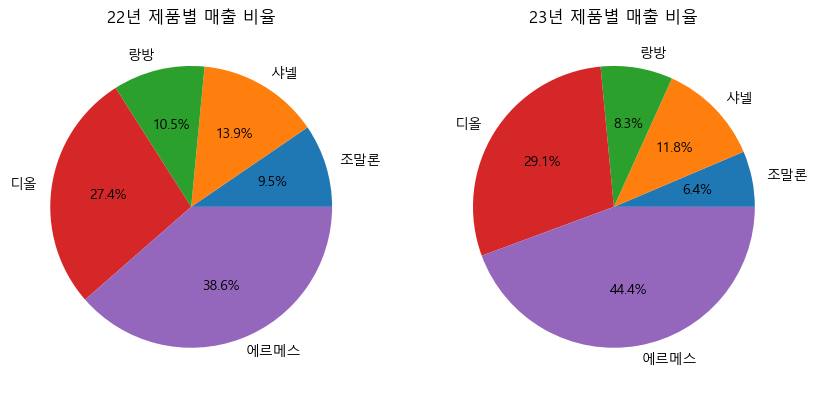

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

##  22년도 제품별 매출
df1_sum = df.loc[df['pdt_22']=='조말론','pur_22'].sum()
df2_sum = df.loc[df['pdt_22']=='샤넬','pur_22'].sum()
df3_sum = df.loc[df['pdt_22']=='랑방','pur_22'].sum()
df4_sum = df.loc[df['pdt_22']=='디올','pur_22'].sum()
df5_sum = df.loc[df['pdt_22']=='에르메스','pur_22'].sum()

data = {'조말론': df1_sum,'샤넬': df2_sum,'랑방': df3_sum,'디올': df4_sum,'에르메스': df5_sum,}
labels = list(data.keys())
sales_22 = list(data.values())

axes[0].pie(sales_22, labels=labels, autopct='%.1f%%')
axes[0].set_title('22년 제품별 매출 비율')

###############################################
##  23년도 제품별 매출

df1_sum = df.loc[df['pdt_23']=='조말론','pur_23'].sum()
df2_sum = df.loc[df['pdt_23']=='샤넬','pur_23'].sum()
df3_sum = df.loc[df['pdt_23']=='랑방','pur_23'].sum()
df4_sum = df.loc[df['pdt_23']=='디올','pur_23'].sum()
df5_sum = df.loc[df['pdt_23']=='에르메스','pur_23'].sum()

data = {'조말론': df1_sum,'샤넬': df2_sum,'랑방': df3_sum,'디올': df4_sum,'에르메스': df5_sum,}
labels = list(data.keys())
sales_23 = list(data.values())

axes[1].pie(sales_23, labels=labels, autopct='%.1f%%')
axes[1].set_title('23년 제품별 매출 비율')
plt.show()

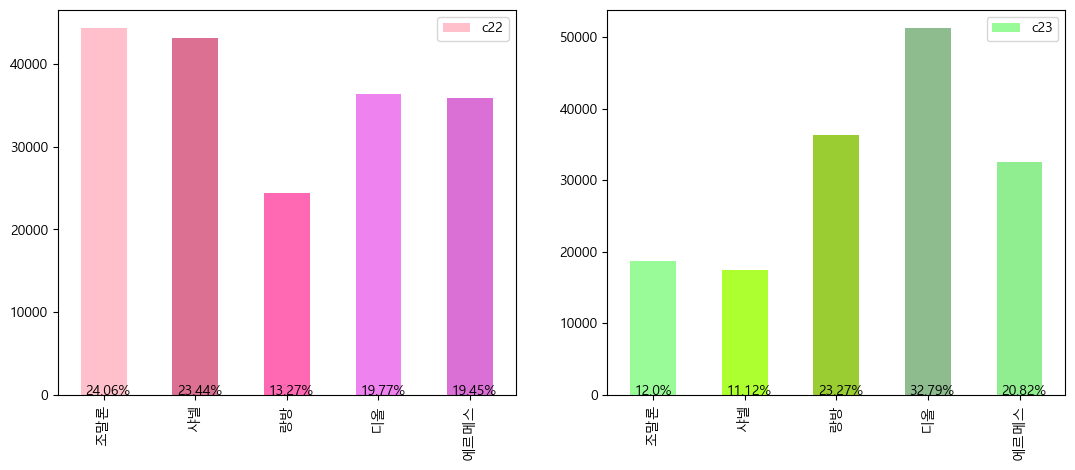

In [75]:
af = df22_23.drop('총계')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

total_22 = af['c22'].sum()
total_23 = af['c23'].sum()

af['c22_ratio'] = (af['c22'] / total_22) * 100
af['c23_ratio'] = (af['c23'] / total_23) * 100

color1=['pink', 'palevioletred','hotpink','violet','orchid']
color2=['palegreen', 'greenyellow','yellowgreen','darkseagreen','lightgreen']
af.plot(y='c22', kind='bar', ax=axes[0], color=color1)
af.plot(y='c23', kind='bar', ax=axes[1], color=color2)

for i, v in enumerate(af['c22_ratio']):
    axes[0].text(i-0.2, v+1, str(round(v,2))+'%', fontsize=10)
for i, v in enumerate(af['c23_ratio']):
    axes[1].text(i-0.2, v+1, str(round(v,2))+'%', fontsize=10)

plt.show()